# Tutorial of GlimpsePrune

In [1]:
import os

import sys
parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if parent_path not in sys.path:
    sys.path.append(parent_path)

import torch
from transformers_gp.models.qwen2_5_vl import (
    Qwen2_5_VL_GP_ForConditionalGeneration,
    Qwen2_5_VL_GP_Processor
)
from transformers.generation.configuration_utils import GenerationConfig
from qwen_vl_utils import process_vision_info
from PIL import Image
import matplotlib.pyplot as plt


/home/azureuser/.conda/envs/dvisual_qwen/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def apply_mask_on_image(image: Image.Image, 
                        mask: torch.Tensor, 
                        alpha: float=0.4, 
                        color: tuple=(0, 255, 0),
                        patch_size: int=28) -> Image.Image:
    """
    Apply a boolean mask on the image.
    Args:
        image (Image.Image): The input image.
        mask (torch.Tensor): A boolean mask of shape (H, W).
    Returns:
        Image.Image: The blended image with the mask applied.
    """
    mask_h, mask_w = mask.shape
    target_h = mask_h * patch_size
    target_w = mask_w * patch_size
    # resize image and mask
    image = image.resize((target_w, target_h), Image.Resampling.LANCZOS)
    mask = torch.nn.functional.interpolate(
        mask.unsqueeze(0).unsqueeze(0).float(),
        size=(target_h, target_w),
        mode='nearest'
    ).squeeze(0).squeeze(0).bool()

    # apply mask with color and alpha
    mask_image = Image.new('RGBA', image.size, color + (0,))
    alpha_data = (mask * 255 * alpha).byte().cpu().numpy()
    alpha_channel = Image.fromarray(alpha_data, mode='L')
    mask_image.putalpha(alpha_channel)
    blended_image = Image.alpha_composite(image.convert('RGBA'), mask_image)
    return blended_image.convert('RGB')
    

In [3]:
base_model = "Qwen/Qwen2.5-VL-7B-Instruct"
new_modules_dir = "../output/qwen2_5_7b_gp"
show_image_token_masks = True
max_remain_ratio = 0.111

model = Qwen2_5_VL_GP_ForConditionalGeneration.from_pretrained(
    base_model,
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    device_map={"": "cuda:0"},
)

processor = Qwen2_5_VL_GP_Processor.from_pretrained(
    base_model,
)

model.load_new_modules(new_modules_dir)

model.eval()


You are using a model of type qwen2_5_vl to instantiate a model of type qwen2_5_vl_gp. This is not supported for all configurations of models and can yield errors.
Loading checkpoint shards: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]
Some weights of Qwen2_5_VL_GP_ForConditionalGeneration were not initialized from the model checkpoint at Qwen/Qwen2.5-VL-7B-Instruct and are newly initialized: ['attn_fuser.attn_in_proj.bias', 'attn_fuser.attn_in_proj.weight', 'attn_fuser.attn_out_projs.0.bias', 'attn_fuser.attn_out_projs.0.weight', 'attn_fuser.cond_in_projs.0.bias', 'attn_fuser.cond_in_projs.0.weight', 'attn_fuser.layers.0.attn.k_proj.weight', 'attn_fuser.layers.0.attn.o_proj.weight', 'attn_fuser.layers.0.attn.q_proj.weight', 'attn_fuser.layers.0.attn.v_proj.weight', 'attn_fuser.layers.0.mlp.down_proj.bias', 'attn_fuser.layers.0.mlp.down_proj.weight', 'attn_fuser.layers.0.mlp.gate_proj.bias', 'attn_fuser.layers.0.mlp.gate_proj.weight', 'attn_fuser.layers.0.mlp.up_proj.bias', 'attn_fuse

new_modules of Qwen2_5_VL_GP_ForConditionalGeneration.le_proj loaded from ../output/qwen2_5_7b_gp/new_modules_gp.pt
new_modules of Qwen2_5_VL_GP_ForConditionalGeneration.le_norm loaded from ../output/qwen2_5_7b_gp/new_modules_gp.pt
new_modules of Qwen2_5_VL_GP_ForConditionalGeneration.learnable_embeddings loaded from ../output/qwen2_5_7b_gp/new_modules_gp.pt
new_modules of Qwen2_5_VL_GP_ForConditionalGeneration.attn_fuser loaded from ../output/qwen2_5_7b_gp/new_modules_gp.pt


Qwen2_5_VL_GP_ForConditionalGeneration(
  (visual): Qwen2_5_VisionTransformerPretrainedModel(
    (patch_embed): Qwen2_5_VisionPatchEmbed(
      (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
    )
    (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
    (blocks): ModuleList(
      (0-31): 32 x Qwen2_5_VLVisionBlock(
        (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
        (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
        (attn): Qwen2_5_VLVisionFlashAttention2(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (mlp): Qwen2_5_VLMLP(
          (gate_proj): Linear(in_features=1280, out_features=3420, bias=True)
          (up_proj): Linear(in_features=1280, out_features=3420, bias=True)
          (down_proj): Linear(in_features=3420, out_features=1280, bias=True)
          (act_fn): SiLU()
        )
      )
    )
    (merger): Qwen2_5_VLPatch

In [4]:
if max_remain_ratio is not None:
    model.config.max_remain_ratio = max_remain_ratio

generation_config = GenerationConfig.from_pretrained(
    base_model,
)
generation_config.max_new_tokens = 1024
print("Generation config:", generation_config)

Generation config: GenerationConfig {
  "bos_token_id": 151643,
  "do_sample": true,
  "eos_token_id": [
    151645,
    151643
  ],
  "max_new_tokens": 1024,
  "pad_token_id": 151643,
  "repetition_penalty": 1.05,
  "temperature": 1e-06
}



## Single Image Inference

In [5]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "../examples/people.png",
            },
            {"type": "text", "text": "What kind of a tie is the groom wearing?"},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to(model.device)

if show_image_token_masks:
    image_grid_thw = inputs.image_grid_thw
    attn_hw = image_grid_thw[0, 1:] // 2
    with torch.inference_mode():
        image_token_bool_masks = model(**inputs, do_selection=True).image_token_bool_masks
    image_token_bool_mask = image_token_bool_masks[0].reshape(
        attn_hw[0].item(), attn_hw[1].item()
    )

# Inference: Generation of the output
model.reset_image_tokens_cache()  # NOTE: reset the cache before inference
with torch.inference_mode():
    generated_ids = model.generate(**inputs, generation_config=generation_config, do_selection=True)  # Enable glimpse prune by do_selection=True
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text[0])

torch.cuda.empty_cache()

The groom in the picture is wearing a light-colored, possibly cream or beige, tie with a subtle pattern that appears to be a small, repeating design, which could be floral or abstract. The tie has a standard width and knot style, which is typical for formal attire.


Retain ratio: 2.3%


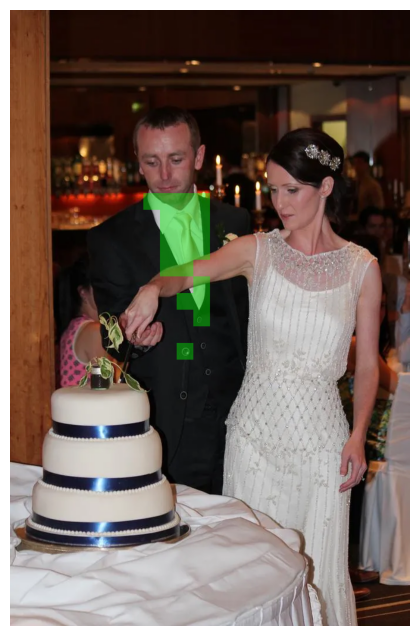

In [6]:
if show_image_token_masks:
    retain_ratio = image_token_bool_mask.float().mean().item()
    print(f"Retain ratio: {retain_ratio*100:.1f}%")

    blended_image = apply_mask_on_image(
        image=Image.open(messages[0]["content"][0]["image"]),
        mask=image_token_bool_mask,
    )

    # Display the blended image
    plt.figure(figsize=(8, 8))
    plt.imshow(blended_image)
    plt.axis("off")
    plt.show()


## Multi Image Inference

In [7]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "../examples/food.png",
            },
            {
                "type": "image",
                "image": "../examples/food2.jpg",
            },
            {"type": "text", "text": "Are there any differences between the foods in the two pictures?"},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to(model.device)

if show_image_token_masks:
    image_grid_thw = inputs.image_grid_thw
    attn_hw = image_grid_thw[:, 1:] // 2
    num_tokens_per_image = torch.prod(attn_hw, dim=1)
    with torch.inference_mode():
        image_token_bool_masks = model(**inputs, do_selection=True).image_token_bool_masks
    image_token_bool_mask_per_image = image_token_bool_masks[0].split(
        num_tokens_per_image.tolist(), dim=0
    )
    num = 0
    image_token_bool_mask_per_image = list(image_token_bool_mask_per_image)
    for i, one_mask in enumerate(image_token_bool_mask_per_image):
        image_token_bool_mask_per_image[i] = one_mask.reshape(
            attn_hw[num, 0].item(), attn_hw[num, 1].item()
        )
        num += 1

# Inference: Generation of the output
model.reset_image_tokens_cache()  # NOTE: reset the cache before inference
with torch.inference_mode():
    generated_ids = model.generate(**inputs, generation_config=generation_config, do_selection=True)  # Enable glimpse prune by do_selection=True
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text[0])

torch.cuda.empty_cache()

Yes, there are significant differences between the foods in the two images:

1. **Image 1 (Pizza):** The food shown is a pizza with various toppings such as sliced tomatoes, green bell peppers, red onions, and possibly other ingredients like cheese or herbs. It appears to be a homemade pizza on a baking tray.

2. **Image 2 (Vegetables):** The food here consists of roasted or sautéed vegetables, including carrots and Brussels sprouts. There may also be some seasoning or oil visible on top of the vegetables.

The primary difference lies in the type of food: one is a savory dish (pizza) while the other is a side dish or vegetable preparation.


Retain ratio for image 1: 12.4%


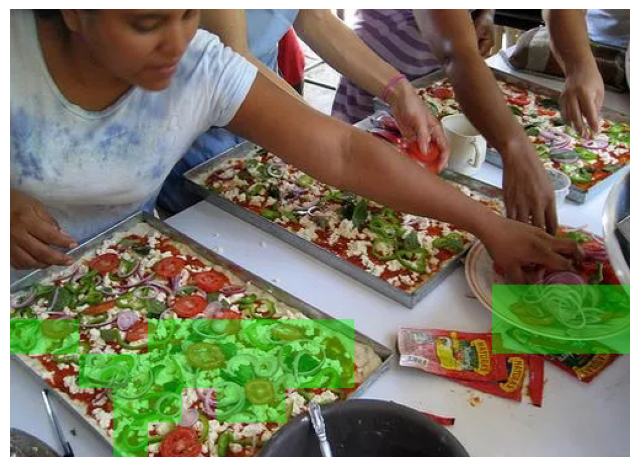

Retain ratio for image 2: 10.1%


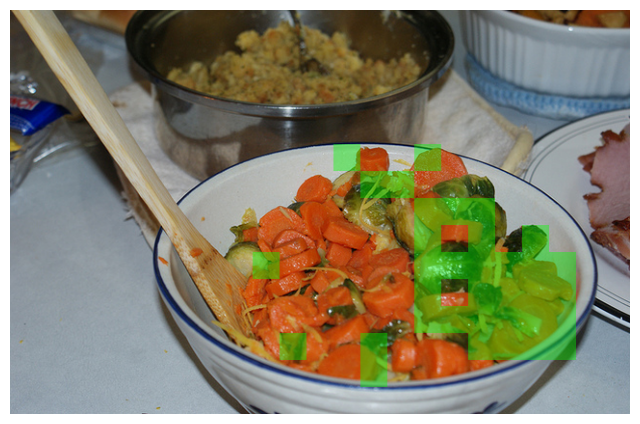

In [8]:
if show_image_token_masks:
    for i, one_mask in enumerate(image_token_bool_mask_per_image):
        retain_ratio = one_mask.float().mean().item()
        print(f"Retain ratio for image {i+1}: {retain_ratio*100:.1f}%")

        
        blended_image = apply_mask_on_image(
            image=Image.open(messages[0]["content"][i]["image"]),
            mask=one_mask,
        )

        # Display the blended image
        plt.figure(figsize=(8, 8))
        plt.imshow(blended_image)
        plt.axis("off")
        plt.show()

## Video Inference

TBD